# DA5401 A5: Visualizing Data Veracity Challenges in Multi-Label Classification

By Muhammad Ruhaib, BE22B005


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import trustworthiness
from scipy.spatial.distance import pdist
from scipy.stats import entropy
from scipy.io import arff

file_path = 'yeast.arff'

# Part A: Preprocessing and Initial Setup

## A.1 Data Loading

In [7]:
data, meta = arff.loadarff(file_path)
df = pd.DataFrame(data)

print("Shape of loaded DataFrame:", df.shape)
df.head()

Shape of loaded DataFrame: (2417, 117)


,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,b'0',b'0',b'1',b'1',b'0',b'0',b'0',b'1',b'1',b'0'
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'1',b'0'
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,b'1',b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'


We see that the dataset consists of 2417 datapoints and 117 columns; out of which 14 correspond to the labels. The values for these labels are still in byte strings, so I'll first convert that to numeric 0's and 1's.

In [8]:
for c in df.columns:
    if df[c].dtype == object:
        df[c] = df[c].apply(lambda v: v.decode() if isinstance(v, (bytes, bytearray)) else v)
        unique_vals = set(df[c].unique())
        if unique_vals <= {'0', '1'}:
            df[c] = df[c].astype(int)

df.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0,0,1,1,0,0,0,1,1,0
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0,0,0,0,0,0,0,0,0,0
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0,0,0,0,0,0,0,1,1,0
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,0,0,0,0,0,0,0,0,0,0
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,1,1,0,0,0,0,0,0,0,0


In [9]:
df.describe()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
count,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,...,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000
mean,0.001173,-0.000436,-0.000257,0.000265,0.001228,0.000475,0.001107,0.000420,0.001076,-0.000009,...,0.298717,0.247000,0.177079,0.198593,0.073645,0.104675,0.119570,0.751345,0.744311,0.014067
std,0.097411,0.097885,0.097746,0.096969,0.096909,0.097306,0.097170,0.096803,0.096326,0.096805,...,0.457790,0.431356,0.381815,0.399024,0.261246,0.306198,0.324525,0.432323,0.436338,0.117792
min,-0.371146,-0.472632,-0.339195,-0.467945,-0.367044,-0.509447,-0.319928,-0.594498,-0.369712,-0.767128,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.053655,-0.058734,-0.057526,-0.057149,-0.058461,-0.060212,-0.058445,-0.062849,-0.063472,-0.065010,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.003649,-0.003513,0.002892,-0.000153,0.005565,0.000321,0.006179,0.001436,0.003515,0.002432,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,0.057299,0.048047,0.061007,0.054522,0.066286,0.059908,0.068892,0.061418,0.064958,0.063096,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,0.520272,0.614114,0.353241,0.568960,0.307649,0.336971,0.351401,0.454591,0.419852,0.420876,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## A.2 Dimensionality Check

In [10]:
for c in df.columns:
    try:
        df[c] = pd.to_numeric(df[c])
    except Exception:
        pass

label_columns = list(df.columns[-14:]) #Given that the last 14 columns are the label columns

feature_columns = [c for c in df.columns if c not in label_columns]
X_df = df[feature_columns].copy()
Y_df = df[label_columns].copy().astype(int)

print('Number of data points (n):', X_df.shape[0])
print('Number of features (d):', X_df.shape[1])
print('Number of labels (L):', Y_df.shape[1])

Number of data points (n): 2417
Number of features (d): 103
Number of labels (L): 14


In [11]:
X_df.head(), Y_df.head()

(       Att1      Att2      Att3      Att4      Att5      Att6      Att7  \
 0  0.004168 -0.170975 -0.156748 -0.142151  0.058781  0.026851  0.197719   
 1 -0.103956  0.011879 -0.098986 -0.054501 -0.007970  0.049113 -0.030580   
 2  0.509949  0.401709  0.293799  0.087714  0.011686 -0.006411 -0.006255   
 3  0.119092  0.004412 -0.002262  0.072254  0.044512 -0.051467  0.074686   
 4  0.042037  0.007054 -0.069483  0.081015 -0.048207  0.089446 -0.004947   
 
        Att8      Att9     Att10  ...     Att94     Att95     Att96     Att97  \
 0  0.041850  0.066938 -0.056617  ...  0.006166 -0.012976 -0.014259 -0.015024   
 1 -0.077933 -0.080529 -0.016267  ...  0.007680  0.027719 -0.085811  0.111123   
 2  0.013646 -0.040666 -0.024447  ...  0.096277 -0.044932 -0.089470 -0.009162   
 3 -0.007670  0.079438  0.062184  ... -0.083809  0.200354 -0.075716  0.196605   
 4  0.064456 -0.133387  0.068878  ... -0.060467  0.044351 -0.057209  0.028047   
 
       Att98     Att99    Att100    Att101    Att102  

## A.3: Label selection for visualization

In [12]:
single_label_mask = (Y_df.sum(axis=1) == 1) #Creates a boolean array for each datapoint; if the datapoint has only one label, then the sum of its label columns will be 1.
single_label_counts = (Y_df[single_label_mask].sum(axis=0)).sort_values(ascending=False)
print('Single-label counts (for instances with exactly one positive label):')
print(single_label_counts)

Single-label counts (for instances with exactly one positive label):
Class1     32
Class2      0
Class3      0
Class4      0
Class5      0
Class6      0
Class7      0
Class8      0
Class9      0
Class10     0
Class11     0
Class12     0
Class13     0
Class14     0
dtype: int64


We see that only one class (class 1) has datapoints that don't belong to any of the other classes; all the other datapoints pertain to multiple labels.

In [48]:
multi_mask = (Y_df.sum(axis=1) > 1) #Creates a boolean array that signifies if a datapoint has multiple labels or not.
if multi_mask.sum() > 0:
    combos = Y_df[multi_mask].apply(lambda row: tuple(row.values.tolist()), axis=1)
    combo_counts = combos.value_counts() #Gets the number of counts for each possible combination of labels that exists
    top_combo = combo_counts.index[0]

print('Counts for each multi-label combination across the dataset:')
print(combo_counts)
print('\nMost frequent multi-label combination (as a tuple of 14 binary values, for each label):')
print(top_combo)

top_combo_labels = [label_columns[i] for i,v in enumerate(top_combo) if v==1]
print('\nMost frequent multi-label combination: ', ', '.join(top_combo_labels))

Counts for each multi-label combination across the dataset:
(0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0)    237
(0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0)    233
(1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0)    172
(1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)    131
(0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0)    117
                                             ... 
(1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0)      1
(1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0)      1
(1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0)      1
(0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0)      1
(0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1)      1
Name: count, Length: 197, dtype: int64

Most frequent multi-label combination (as a tuple of 14 binary values, for each label):
(0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0)

Most frequent multi-label combination:  Class3, Class4, Class12, Class13


In [14]:
top2_single = list(single_label_counts.index[:2])
print('\nTop-2 single-label classes chosen for visualization:', top2_single)

viz_labels = []
for i in range(Y_df.shape[0]):
    row = Y_df.iloc[i]
    if row.sum() == 1:
        lab = row[row==1].index[0]
        if lab == top2_single[0]:
            viz_labels.append(top2_single[0])
        elif lab == top2_single[1]:
            viz_labels.append(top2_single[1])
        else:
            viz_labels.append('Other')
    elif row.sum() > 1 and top_combo is not None and tuple(row.values.tolist()) == top_combo:
        viz_labels.append(f'Multi: {", ".join(top_combo_labels)}')
    else:
        viz_labels.append('Other')

viz_labels = pd.Series(viz_labels, name='viz_label')
print('\nViz label distribution:')
print(viz_labels.value_counts())

combined = pd.concat([X_df.reset_index(drop=True), Y_df.reset_index(drop=True), viz_labels.reset_index(drop=True)], axis=1)
combined.head(10)


Top-2 single-label classes chosen for visualization: ['Class1', 'Class2']

Viz label distribution:
viz_label
Other                                      2148
Multi: Class3, Class4, Class12, Class13     237
Class1                                       32
Name: count, dtype: int64


,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14,viz_label
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0,1,1,0,0,0,1,1,0,Other
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0,0,0,0,0,0,0,0,0,Other
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0,0,0,0,0,0,1,1,0,Other
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,0,0,0,0,0,0,0,0,0,Other
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,1,0,0,0,0,0,0,0,0,Other
5,0.003286,-0.023601,-0.023104,-0.064171,-0.017719,-0.113510,-0.035212,-0.077675,-0.024348,-0.012458,...,0,0,0,0,1,1,1,1,0,Other
6,0.076606,-0.025478,0.072419,-0.065383,0.123539,0.120130,0.102248,0.008324,0.094147,-0.014666,...,0,0,0,0,0,0,1,1,0,Other
7,-0.106801,-0.069277,-0.132254,-0.099246,-0.188413,-0.110359,-0.155120,-0.168094,-0.182473,0.023208,...,0,0,0,0,0,0,1,1,0,Other
8,0.177650,0.136159,0.153211,0.190312,0.158541,0.219521,0.079914,0.232238,0.127932,0.089142,...,0,0,0,0,0,0,1,1,0,Other
9,0.122075,-0.055828,-0.034775,-0.039235,0.075027,0.087308,0.088062,0.122385,0.091848,-0.099132,...,0,0,0,0,0,0,1,1,0,"Multi: Class3, Class4, Class12, Class13"


## A.4: Scaling

Standardization (zero mean, unit variance) is applied because t-SNE and Isomap rely on distances; features with larger scales would otherwise dominate.

In [15]:
scaler = StandardScaler()
X = scaler.fit_transform(X_df.values)
print('Scaled feature matrix shape:', X.shape)
X_scaled_df = pd.DataFrame(X, columns=X_df.columns)
X_scaled_df.head()

Scaled feature matrix shape: (2417, 103)


,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att94,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103
0,0.030752,-1.742591,-1.601326,-1.468980,0.594010,0.271117,2.023802,0.428070,0.683885,-0.584890,...,0.074380,-0.139039,-0.142884,-0.162409,-0.115009,0.020075,-0.320076,-0.178076,0.320417,1.178867
1,-1.079454,0.125835,-1.010264,-0.564893,-0.094933,0.499948,-0.326167,-0.809579,-0.847347,-0.167984,...,0.090608,0.281957,-0.886751,1.143263,0.521680,0.307877,-0.645355,-0.423947,-0.859425,0.096189
2,5.224059,4.109170,3.008988,0.902018,0.107939,-0.070783,-0.075781,0.136654,-0.433427,-0.252502,...,1.040237,-0.469629,-0.924791,-0.101735,-0.128129,3.284185,-0.278757,0.299908,-0.717769,-1.308110
3,1.210780,0.049537,-0.020516,0.742552,0.446738,-0.533913,0.757376,-0.083592,0.813679,0.642590,...,-0.890019,2.067892,-0.781802,2.028035,1.583559,-0.286180,-0.755161,-0.930956,-0.538974,-0.518363
4,0.419587,0.076533,-0.708369,0.832919,-0.510222,0.914530,-0.062317,0.661644,-1.396200,0.711754,...,-0.639827,0.454017,-0.589400,0.283393,0.304769,-0.514501,0.250775,-0.637002,-0.380569,0.606249


# Part B: t-SNE and Veracity Inspection

## B.1 and B.2: t-SNE implementation and visualization

In [16]:
def scatter_with_legend(ax, coords, labels, title=None, s=20): #helper function for scatter plots
    unique = list(pd.Categorical(labels).categories)
    for u in unique:
        mask = (labels == u)
        ax.scatter(coords[mask, 0], coords[mask, 1], label=str(u), s=s)
    ax.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    if title:
        ax.set_title(title)

With perplexity = 5:

Running t-SNE with perplexity = 5


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE (perp=5) produced shape (2417, 2)


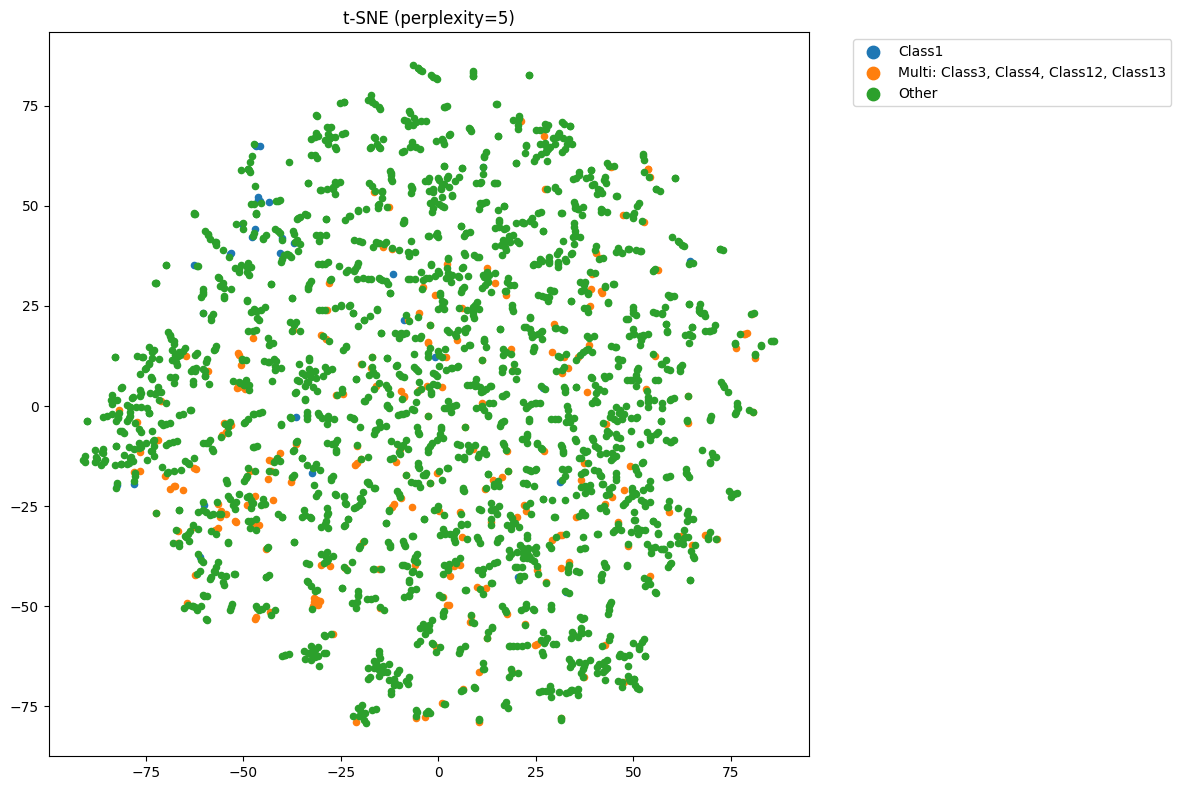

In [17]:
from sklearn.manifold import TSNE
perp = 5
print('Running t-SNE with perplexity =', perp)
tsne5 = TSNE(n_components=2, perplexity=perp, init='pca', random_state=42, n_iter=1000)
X_tsne_5 = tsne5.fit_transform(X)
print('t-SNE (perp=5) produced shape', X_tsne_5.shape)

fig, ax = plt.subplots(figsize=(12, 8))
scatter_with_legend(ax, X_tsne_5, viz_labels.values, title=f't-SNE (perplexity={perp})')
plt.tight_layout()
plt.show()

With perplexity = 30:

Running t-SNE with perplexity = 30


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE (perp=30) produced shape (2417, 2)


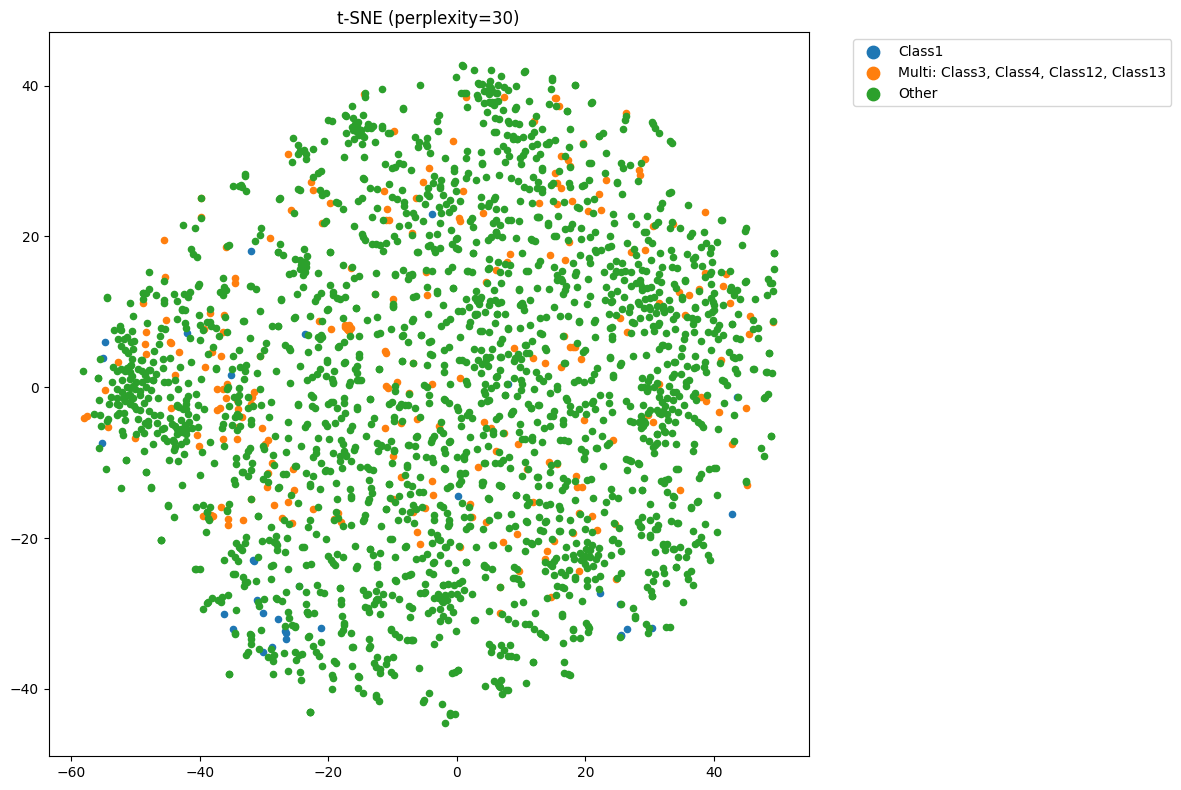

In [18]:
perp = 30
print('Running t-SNE with perplexity =', perp)
tsne30 = TSNE(n_components=2, perplexity=perp, init='pca', random_state=42, n_iter=1000)
X_tsne_30 = tsne30.fit_transform(X)
print('t-SNE (perp=30) produced shape', X_tsne_30.shape)

fig, ax = plt.subplots(figsize=(12, 8))
scatter_with_legend(ax, X_tsne_30, viz_labels.values, title=f't-SNE (perplexity={perp})')
plt.tight_layout()
plt.show()

With perplexity = 50:

Running t-SNE with perplexity = 50


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE (perp=50) produced shape (2417, 2)


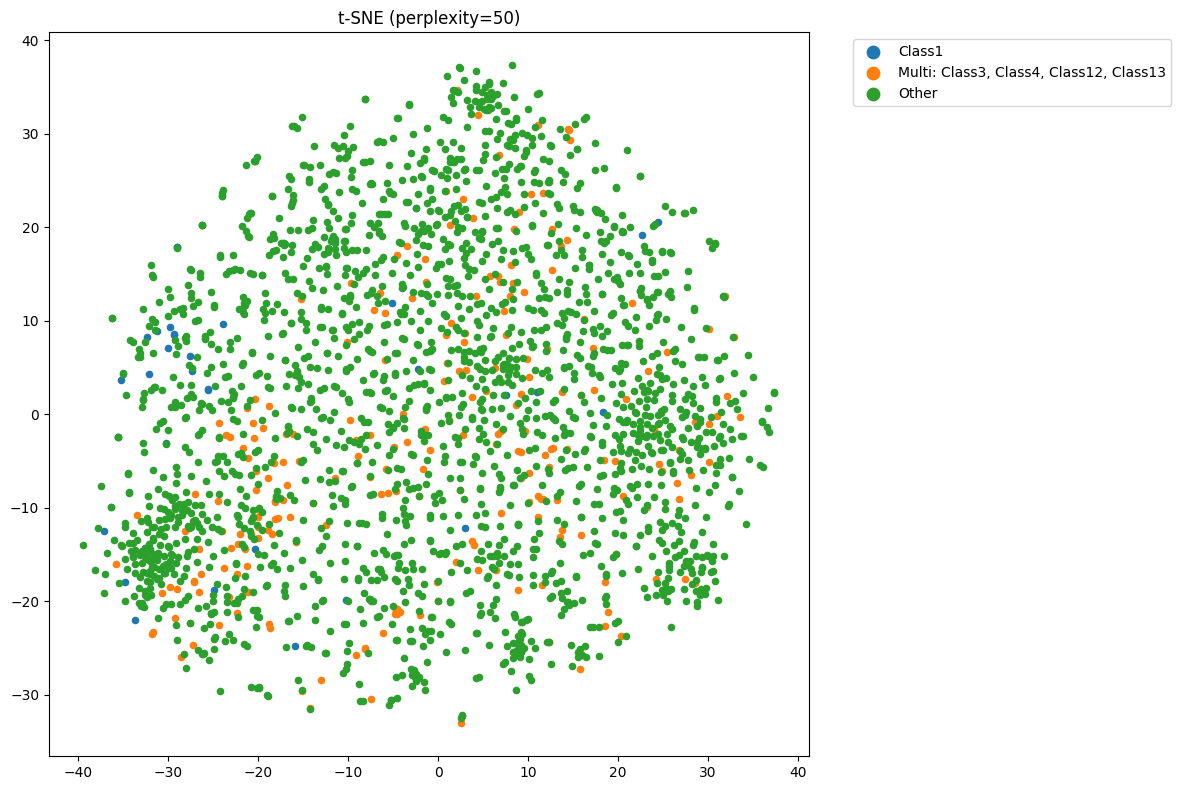

In [19]:
perp = 50
print('Running t-SNE with perplexity =', perp)
tsne50 = TSNE(n_components=2, perplexity=perp, init='pca', random_state=42, n_iter=1000)
X_tsne_50 = tsne50.fit_transform(X)
print('t-SNE (perp=50) produced shape', X_tsne_50.shape)

fig, ax = plt.subplots(figsize=(12, 8))
scatter_with_legend(ax, X_tsne_50, viz_labels.values, title=f't-SNE (perplexity={perp})')
plt.tight_layout()
plt.show()

Considering that we have a large number of datapoints and that our goal is to better understand the overall topology of the data while still being able to detect outliers, I believe it would be better to choose 30 as our perplexity value. It strikes a balance between preserving the global and local structures. A lower perplexity would focus too much on local clusters, whereas a higher one would focus too much on the global structure.

In [39]:
X_tsne = X_tsne_30

## Part B.3: Veracity Inspection

In [40]:
from sklearn.neighbors import NearestNeighbors
k = 20
nn = NearestNeighbors(n_neighbors=k+1).fit(X_tsne)
dists, inds = nn.kneighbors(X_tsne)
neighbor_inds = inds[:,1:]
labels_arr = viz_labels.values
noisy_candidates = []
hard_entropy = []
for i in range(X_tsne.shape[0]):
    neigh = labels_arr[neighbor_inds[i]]
    c = Counter(neigh)
    most_label, most_count = c.most_common(1)[0]
    if most_label != labels_arr[i] and most_count >= (k//2):
        noisy_candidates.append(i)
    freqs = np.array([c.get(lbl,0) for lbl in pd.Categorical(labels_arr).categories], dtype=float)
    ent = entropy(freqs/freqs.sum(), base=2) if freqs.sum() > 0 else 0.0
    hard_entropy.append(ent)

noisy_candidates = np.array(noisy_candidates)
hard_entropy = np.array(hard_entropy)
print('Noisy candidates flagged:', noisy_candidates.size)
print('Hard entropy quantiles:')
print(pd.Series(hard_entropy).quantile([0.5,0.75,0.9,0.95]))

Noisy candidates flagged: 269
Hard entropy quantiles:
0.50    0.468996
0.75    0.721928
0.90    0.811278
0.95    0.934068
dtype: float64


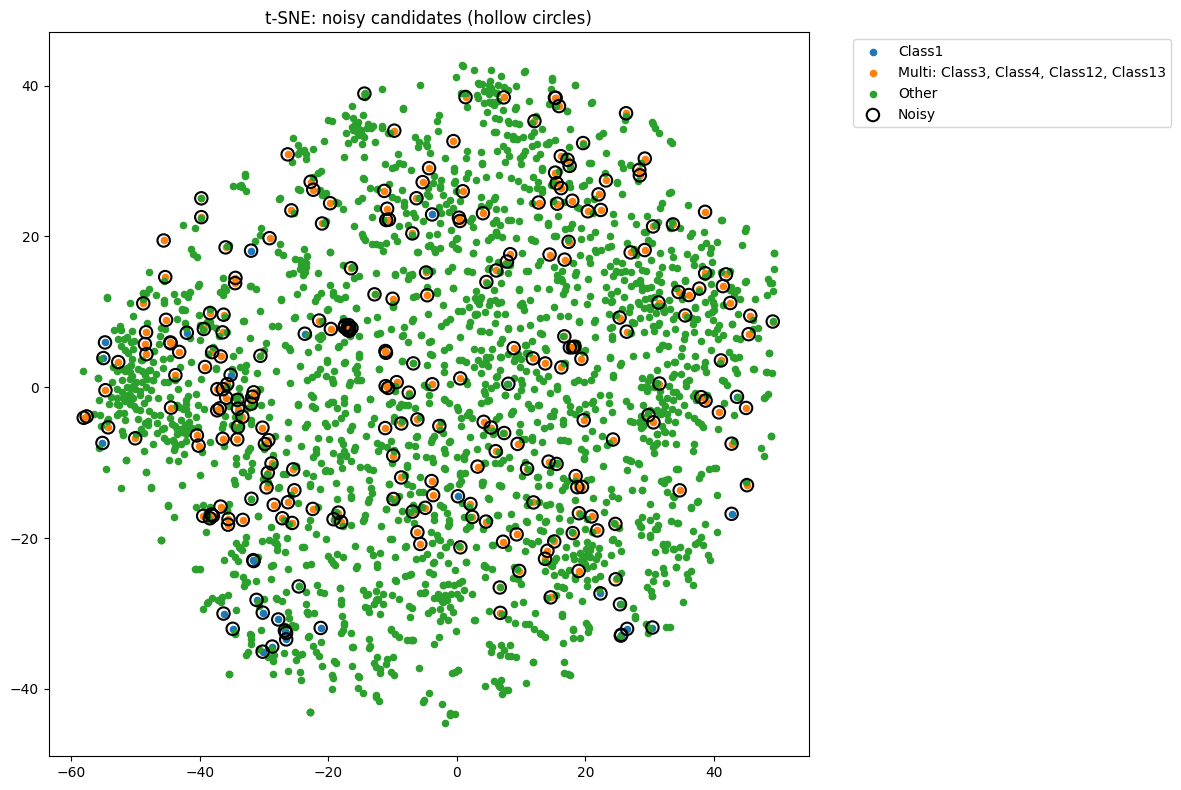

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))
scatter_with_legend(ax, X_tsne, viz_labels.values, title='t-SNE: noisy candidates (hollow circles)')
if noisy_candidates.size > 0:
    ax.scatter(X_tsne[noisy_candidates,0], X_tsne[noisy_candidates,1], facecolors='none', edgecolors='k', s=80, linewidths=1.5, label='Noisy')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

As most of the class-1 and multi-label points are spread across the plot, they accordingly get picked up as noisy labels as they are embedded alongside the 'other' label points.

Outliers (>=99th percentile): 25


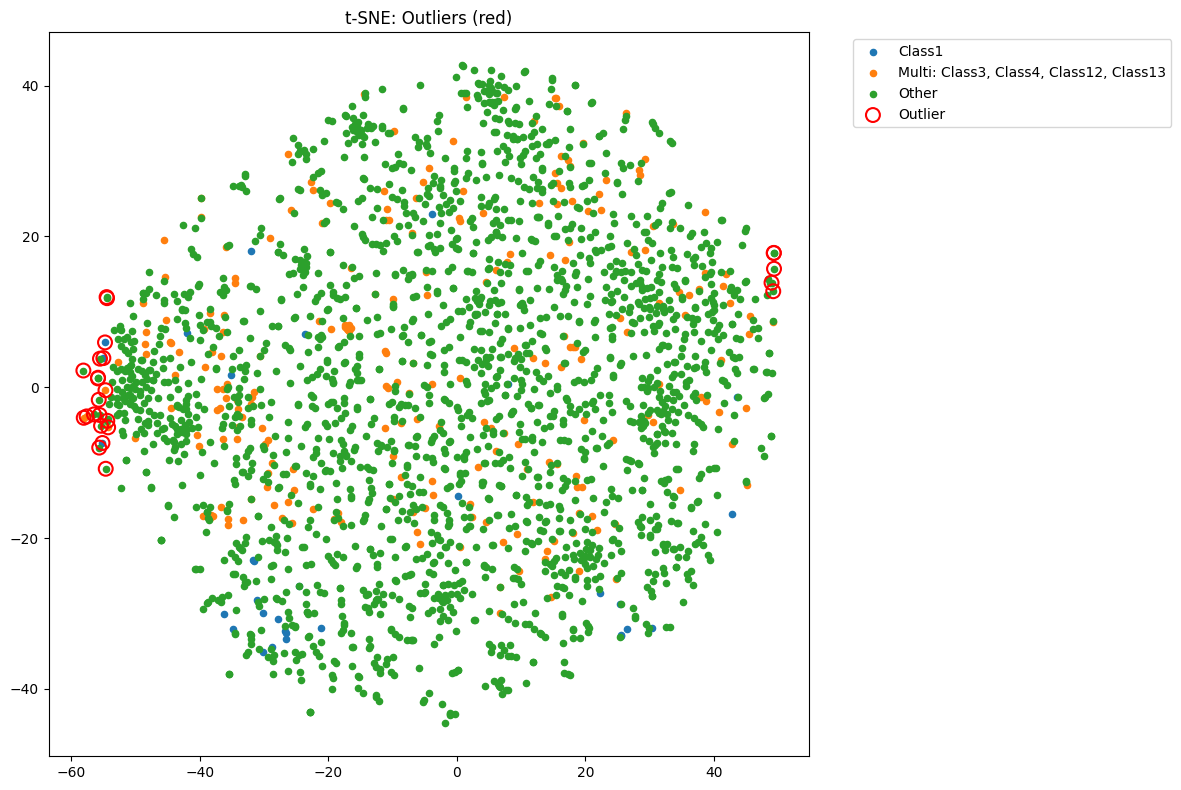

In [42]:
centroid = X_tsne.mean(axis=0)
dists = np.linalg.norm(X_tsne - centroid, axis=1)
thresh = np.percentile(dists, 99)
outliers = np.where(dists >= thresh)[0]
print('Outliers (>=99th percentile):', outliers.size)

fig, ax = plt.subplots(figsize=(12, 8))
scatter_with_legend(ax, X_tsne, viz_labels.values, title='t-SNE: Outliers (red)')
if outliers.size > 0:
    ax.scatter(X_tsne[outliers,0], X_tsne[outliers,1], facecolors='none', edgecolors='red', s=100, linewidths=1.5, label='Outlier')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

We see outliers at the left and right extremes of the plot, which could represent datapoints whose gene expression profiles are highly unusual as compared to that of the rest of the dataset.

Hard-to-learn (top 5% by entropy): 131


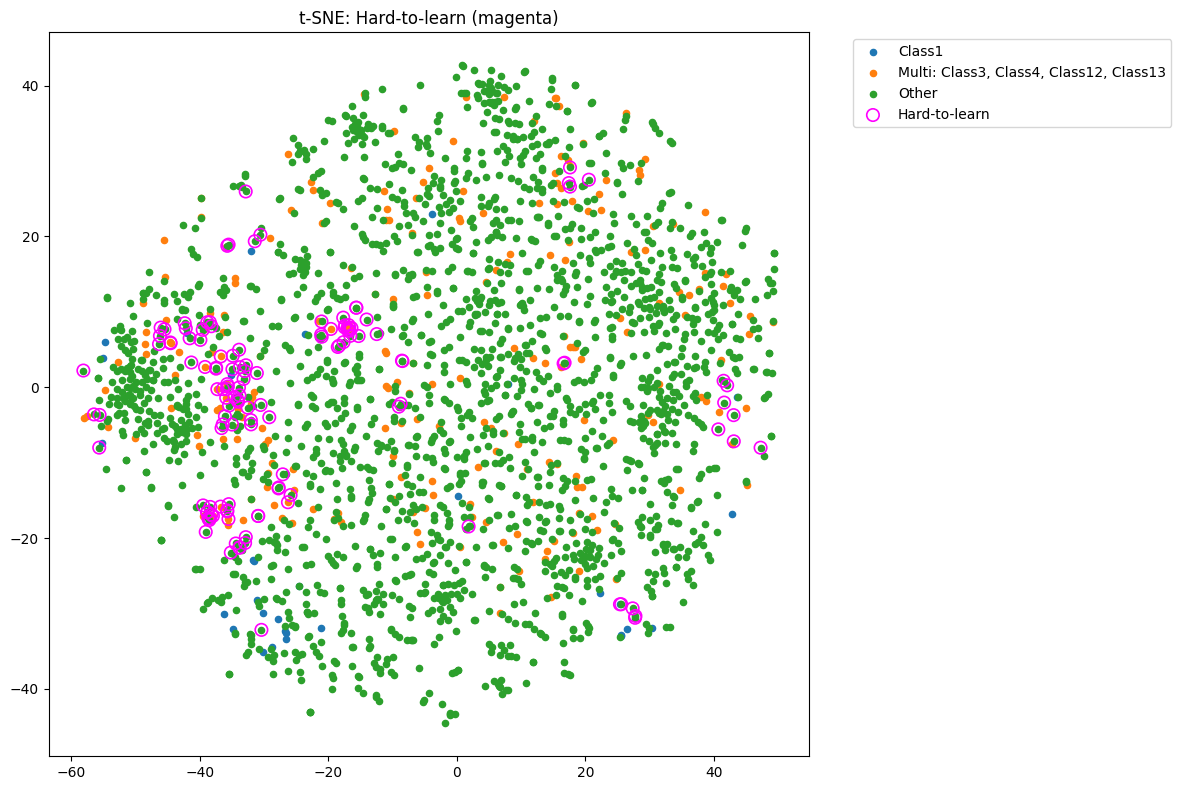

In [43]:
ent_thresh = np.percentile(hard_entropy, 95)
hard_idx = np.where(hard_entropy >= ent_thresh)[0]
print('Hard-to-learn (top 5% by entropy):', hard_idx.size)

fig, ax = plt.subplots(figsize=(12, 8))
scatter_with_legend(ax, X_tsne, viz_labels.values, title='t-SNE: Hard-to-learn (magenta)')
if hard_idx.size > 0:
    ax.scatter(X_tsne[hard_idx,0], X_tsne[hard_idx,1], facecolors='none', edgecolors='magenta', s=80, linewidths=1.2, label='Hard-to-learn')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

As seen above, hard-to-learn samples tend to occur where the feature space for different classes overlaps or is ambiguous (i.e., no clear boundaries between them) which makes it challenging for classifiers to assign the correct label. In practice, these regions correspond to functionally complex or borderline samples where label assignments are likely non-trivial, potentially reflecting multi-functional genes or experimental ambiguity.

A simple classifier (like logistic regression or a basic decision tree) typically relies on clear, linear, or axis-aligned boundaries, and struggles to represent complex relationships.

# Part C: Isomap and Manifold Learning

## C.1: Isomap implementation

In [46]:
from sklearn.manifold import Isomap
n_neighbors = 10
iso = Isomap(n_neighbors=n_neighbors, n_components=2)
X_iso = iso.fit_transform(X)
print('Isomap embedding shape:', X_iso.shape)

Isomap embedding shape: (2417, 2)


Isomap is a manifold learning method that aims to preserve the global geometric structure of the data. It does this by approximating the geodesic (shortest path) distance between all pairs of points in the high-dimensional space using a neighborhood graph, then performing classical multidimensional scaling to embed the data in a lower-dimensional space. As such, Isomap tries to keep far-apart points distant and maintains overall data topology, making it good for visualizing continuous manifolds or large-scale relationships.

On the other hand, t-SNE focuses on preserving local neighborhood structure. It transforms affinities of data points into probabilities (both in high- and low-dimensional space) and arranges points to minimize the mismatch between these probabilities, especially prioritizing accurate representation of close neighbors. It can significantly deform the global geometry; clusters might be split, rotated, or re-sized to best reflect local similarities.

## C.2 Visualization

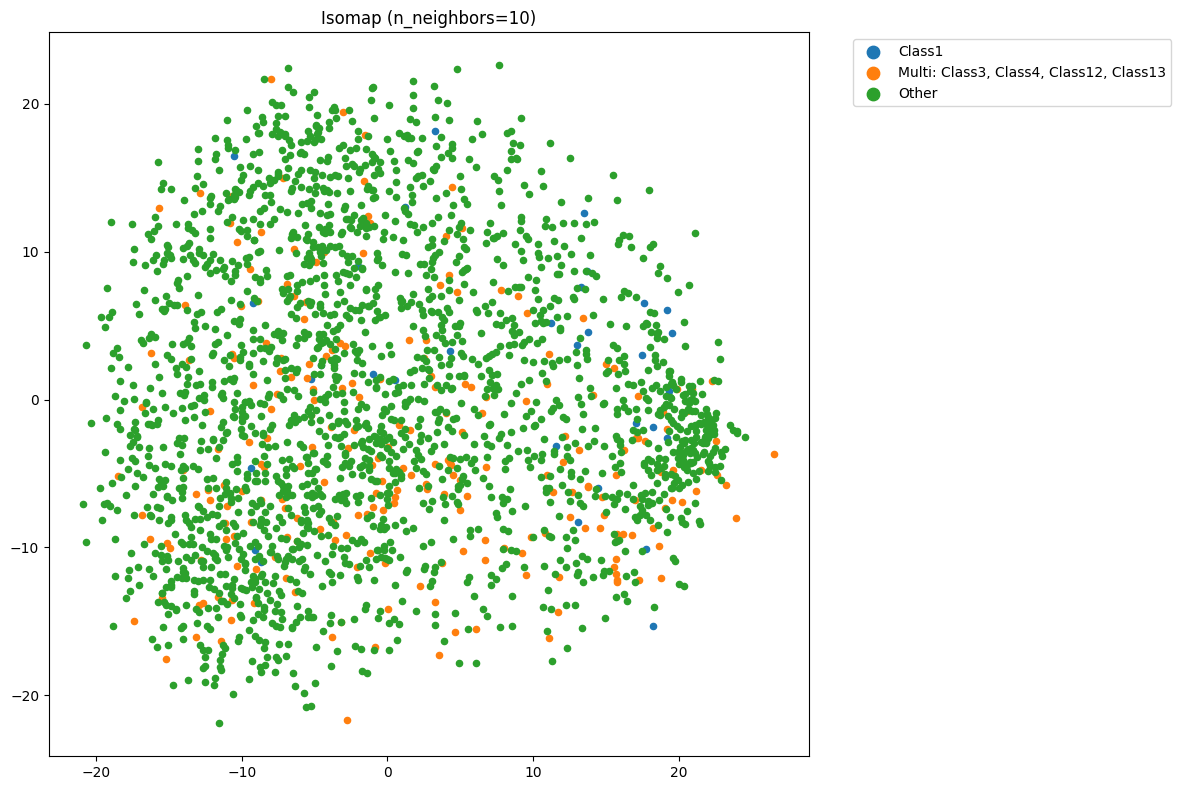

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))
scatter_with_legend(ax, X_iso, viz_labels.values, title=f'Isomap (n_neighbors={n_neighbors})')
plt.tight_layout()
plt.show()

## C.3 Comparison and Curvature

### Isomap v/s t-SNE:

The Isomap plot better reveals the global structure of the gene expression data. It preserves overall distances more faithfully, showing a more continuous and smooth layout without fragmented or tightly clumped clusters. In contrast, t-SNE produces distinct local clusters and emphasizes local neighborhood relations but often breaks global geometry, as seen in its more scattered and separated clusters.

I've also tried gauging which method is better by using the trustworthiness and pairwise embedding distances correlation metrics:

In [45]:
trust_tsne = trustworthiness(X, X_tsne, n_neighbors=10)
trust_iso  = trustworthiness(X, X_iso,  n_neighbors=10)
print('Trustworthiness: t-SNE =', trust_tsne, ', Isomap =', trust_iso)

n = X.shape[0]
max_sample = 800
if n > max_sample:
    rng = np.random.RandomState(0)
    idx = rng.choice(n, size=max_sample, replace=False)
    Xs = X[idx]
    Ts = X_tsne[idx]
    Is = X_iso[idx]
else:
    Xs = X
    Ts = X_tsne
    Is = X_iso

Dh = pdist(Xs, metric='euclidean')
Dt = pdist(Ts, metric='euclidean')
Di = pdist(Is, metric='euclidean')

corr_tsne = np.corrcoef(Dh, Dt)[0,1]
corr_iso  = np.corrcoef(Dh, Di)[0,1]
print('Pairwise distance corr: t-SNE =', corr_tsne, ', Isomap =', corr_iso)

import pandas as pd
summary = pd.DataFrame({'method':['t-SNE','Isomap'],
                        'trustworthiness':[trust_tsne, trust_iso],
                        'pairwise_distance_corr':[corr_tsne, corr_iso]})
summary

Trustworthiness: t-SNE = 0.9283553385257507 , Isomap = 0.721583919028679
Pairwise distance corr: t-SNE = 0.4293414370481238 , Isomap = 0.49842448510797516


,method,trustworthiness,pairwise_distance_corr
0,t-SNE,0.928355,0.429341
1,Isomap,0.721584,0.498424


We see that t-SNE achieves significantly higher trustworthiness, indicating it better preserves local neighborhood relationships. This means that points close in high-dimensional space remain close in the embedding, consistent with t-SNE's design to maintain local structure.

Isomap has a slightly higher correlation of pairwise distances, showing it better preserves the global distance relationships between points compared to t-SNE. This fits Isomap's aim to preserve global geometry.

### Data Manifolds:

A data manifold is a lower-dimensional, continuous surface embedded within a higher-dimensional space, on which real-world data points tend to lie. In machine learning, the manifold hypothesis suggests that even though data like images or gene expression profiles have many features, the essential variation among samples can be captured by a much smaller number of underlying dimensions. Manifold learning techniques seek to uncover and exploit this lower-dimensional structure for visualization, analysis, or dimensionality reduction.

The Isomap visualization suggests a moderately curved and complex manifold. The embedding shows a continuous surface with some curvature and spread rather than simple linear clustering, meaning the original high-dimensional data lie on a nonlinear manifold. This curvature indicates that gene expression patterns are governed by complex underlying factors.

Complex manifolds imply that the data classes are intertwined in nonlinear ways, increasing classification difficulty. Class boundaries may curve or overlap in this manifold, making it hard for simple or linear classifiers to separate classes perfectly. Increased manifold complexity often correlates with overlapping classes or ambiguous samples, requiring more sophisticated models to capture the true data structure.